# 検出した気泡から角度情報を計算する

In [291]:
import struct
import numpy as np
import os
import re
import matplotlib.pyplot as plt

In [292]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2
from src import OpenFile,visualizer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [293]:
#入力データのディレクトリ
data_path=r"E:\0_Experiment\2024-06-11_yolo_predict_model\1_AnalData\2024-06-13_tracking_result\2024-06-13_tracking_result\results"
extension=".txt"
common_name,file_names=OpenFile.get_shared_name(data_path=data_path, extension=extension)

In [294]:
data_txts=[]
for file in file_names:
    # 正規表現パターンを生成
    pattern = r"{}(\d+){}".format(re.escape(common_name), re.escape(extension))
    frame = int(re.search(pattern, file).group(1))
    data_txts.append([frame,file])
    print("frame:",frame,", file:", file)
    
print("ファイル数: ",len(data_txts))

frame: 1 , file: result_for_panasonic_0225_2024_S0001_frame_1.txt
frame: 10 , file: result_for_panasonic_0225_2024_S0001_frame_10.txt
frame: 100 , file: result_for_panasonic_0225_2024_S0001_frame_100.txt
frame: 1000 , file: result_for_panasonic_0225_2024_S0001_frame_1000.txt
frame: 1001 , file: result_for_panasonic_0225_2024_S0001_frame_1001.txt
frame: 1002 , file: result_for_panasonic_0225_2024_S0001_frame_1002.txt
frame: 1003 , file: result_for_panasonic_0225_2024_S0001_frame_1003.txt
frame: 1004 , file: result_for_panasonic_0225_2024_S0001_frame_1004.txt
frame: 1005 , file: result_for_panasonic_0225_2024_S0001_frame_1005.txt
frame: 1006 , file: result_for_panasonic_0225_2024_S0001_frame_1006.txt
frame: 1007 , file: result_for_panasonic_0225_2024_S0001_frame_1007.txt
frame: 1008 , file: result_for_panasonic_0225_2024_S0001_frame_1008.txt
frame: 1009 , file: result_for_panasonic_0225_2024_S0001_frame_1009.txt
frame: 101 , file: result_for_panasonic_0225_2024_S0001_frame_101.txt
frame:

## ファイル読み込み(気泡情報抽出)

In [295]:
#パラメータ
scale_mm_px= 0.007811457 #スケール[ mm/px]
fps = 30000 #撮影速度 [ fps ]

In [296]:
import pandas as pd 
df_frames = None
for data_txt in data_txts:
    #csv形式のtxtファイルを読み込む
    #Object ID:物体の種類(0:bubble)	Identity:気泡のトラッキングID?	BBox X1	BBox Y1	BBox X2	BBox Y2
    if df_frames is None: 
        df_frames = pd.read_csv(os.path.join(data_path,data_txt[1]))
        df_frames['frame']=data_txt[0]
        
    else:
        df_frame = pd.read_csv(os.path.join(data_path,data_txt[1]))
        df_frame['frame'] = data_txt[0]
        df_frames = pd.concat([df_frames, df_frame], axis=0 )


## Identityによる分類


In [297]:
df_frames["center_X"]=df_frames.apply(lambda row:  (row['BBox X2']+row['BBox X1'])/2 , axis=1)
df_frames["center_Y"]= df_frames.apply(lambda row:  (row['BBox Y2']+row['BBox Y1'])/2 , axis=1)

df_sort_grouped = df_frames.groupby('Identity').apply(lambda x : x.sort_values(by='Identity'))
df_sort= df_frames.groupby('Identity').apply(lambda x: x.sort_values(by='frame')).reset_index(drop=True)
df_sort

C:\TEMP\ipykernel_10296\2539740116.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sort_grouped = df_frames.groupby('Identity').apply(lambda x : x.sort_values(by='Identity'))
C:\TEMP\ipykernel_10296\2539740116.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sort= df_frames.groupby('Identity').apply(lambda x: x.sort_values(by='frame')).reset_index(drop=True)


,Object ID,Identity,BBox X1,BBox Y1,BBox X2,BBox Y2,frame,center_X,center_Y
0,0,1,416,369,440,394,3,428.0,381.5
1,0,1,417,370,440,395,4,428.5,382.5
2,0,1,419,371,441,395,5,430.0,383.0
3,0,1,419,372,442,395,6,430.5,383.5
4,0,1,420,372,443,396,7,431.5,384.0
...,...,...,...,...,...,...,...,...,...
37314,0,4867,322,745,340,764,2999,331.0,754.5
37315,0,4867,322,747,340,766,3000,331.0,756.5
37316,0,4867,322,749,340,768,3001,331.0,758.5
37317,0,4868,429,912,442,926,2944,435.5,919.0


# 流速＆角度を求める


In [298]:
target_columns = [ 'Identity', 'center_X', 'center_Y', 'frame']
df_grouped_identity= df_sort[target_columns].groupby('Identity')

df_cal_vec = None

for group_name, group_data in df_grouped_identity:
    group_data['vec_X'] = group_data['center_X'].diff()/group_data['frame'].diff()
    group_data['vec_Y'] = group_data['center_Y'].diff()/group_data['frame'].diff()
    group_data['vec_val'] =np.sqrt( group_data['vec_X'].pow(2)+group_data['vec_Y'].pow(2)) 
    group_data['cos_from_flow'] = -group_data['vec_Y']/group_data['vec_val']


    if df_cal_vec is None:
        df_cal_vec = group_data
    else:
        df_cal_vec= pd.concat([df_cal_vec,group_data], ignore_index=True )
df_cal_vec

,Identity,center_X,center_Y,frame,vec_X,vec_Y,vec_val,cos_from_flow
0,1,428.0,381.5,3,NaN,NaN,NaN,NaN
1,1,428.5,382.5,4,0.5,1.0,1.118034,-0.894427
2,1,430.0,383.0,5,1.5,0.5,1.581139,-0.316228
3,1,430.5,383.5,6,0.5,0.5,0.707107,-0.707107
4,1,431.5,384.0,7,1.0,0.5,1.118034,-0.447214
...,...,...,...,...,...,...,...,...
37314,4867,331.0,754.5,2999,0.0,2.0,2.000000,-1.000000
37315,4867,331.0,756.5,3000,0.0,2.0,2.000000,-1.000000
37316,4867,331.0,758.5,3001,0.0,2.0,2.000000,-1.000000
37317,4868,435.5,919.0,2944,NaN,NaN,NaN,NaN


## フレームが離れすぎたときはIdentityを区別する

In [323]:
diff_max = 20
# df_cal_cec_sort = df_cal_vec.sort_values(by=['Identity', 'Frame']).reset_index(drop=True)

# 新しいIdentityを作成するための列を追加
df_cal_vec['New_Identity'] = df_cal_vec['Identity']

for identity, group in df_cal_vec.groupby('Identity'):
    #フレームの差分
    frame_diff = group['frame'].diff().fillna(0)
    # identityを区別する
    new_identity_starts = frame_diff >= diff_max
    # 新しいIdentityのインデックスを取得
    new_identity_indices = group.index[new_identity_starts]

    # 新しいIdentityを割り当て
    new_id = df_cal_vec['New_Identity'].max() + 1
    for idx in new_identity_indices:
        df_cal_vec.loc[idx:, 'New_Identity'] += 1
        new_id += 1
df_cal_vec

,Identity,center_X,center_Y,frame,vec_X,vec_Y,vec_val,cos_from_flow,New_Identity
0,1,428.0,381.5,3,NaN,NaN,NaN,NaN,1
1,1,428.5,382.5,4,0.5,1.0,1.118034,-0.894427,1
2,1,430.0,383.0,5,1.5,0.5,1.581139,-0.316228,1
3,1,430.5,383.5,6,0.5,0.5,0.707107,-0.707107,1
4,1,431.5,384.0,7,1.0,0.5,1.118034,-0.447214,1
...,...,...,...,...,...,...,...,...,...
37314,4867,331.0,754.5,2999,0.0,2.0,2.000000,-1.000000,6490
37315,4867,331.0,756.5,3000,0.0,2.0,2.000000,-1.000000,6490
37316,4867,331.0,758.5,3001,0.0,2.0,2.000000,-1.000000,6490
37317,4868,435.5,919.0,2944,NaN,NaN,NaN,NaN,6491


# フィルタリングをする

1. 流速制限
1. 個数制限
1. フレーム間隔制限

In [324]:
frame_min=5
thredhold_min =60
diff_max = 30
grouped=df_cal_vec.reset_index(drop=True).groupby('New_Identity')
filtered = grouped.filter(lambda x: x['vec_val'].max()<= thredhold_min)
filtered = filtered.groupby('New_Identity').filter( (lambda x: x['frame'].nunique() >= frame_min) )
filtered = filtered.groupby('New_Identity').filter( (lambda x : x['frame'].diff().max() < diff_max))
df_filtered_vec=filtered
df_filtered_vec


,Identity,center_X,center_Y,frame,vec_X,vec_Y,vec_val,cos_from_flow,New_Identity
0,1,428.0,381.5,3,NaN,NaN,NaN,NaN,1
1,1,428.5,382.5,4,0.5,1.0,1.118034,-0.894427,1
2,1,430.0,383.0,5,1.5,0.5,1.581139,-0.316228,1
3,1,430.5,383.5,6,0.5,0.5,0.707107,-0.707107,1
4,1,431.5,384.0,7,1.0,0.5,1.118034,-0.447214,1
...,...,...,...,...,...,...,...,...,...
37312,4867,332.0,750.5,2997,0.0,2.5,2.500000,-1.000000,6490
37313,4867,331.0,752.5,2998,-1.0,2.0,2.236068,-0.894427,6490
37314,4867,331.0,754.5,2999,0.0,2.0,2.000000,-1.000000,6490
37315,4867,331.0,756.5,3000,0.0,2.0,2.000000,-1.000000,6490


In [301]:
array_cos = df_filtered_vec.cos_from_flow.values
print(array_cos[~np.isnan(array_cos)].shape)
print(df_filtered_vec.center_X.values.shape)

(28501,)
(31864,)


## 全体軌跡表示

# あるフレームを含むIdentityの軌跡を表示

<function matplotlib.pyplot.legend(*args, **kwargs) -> 'Legend'>

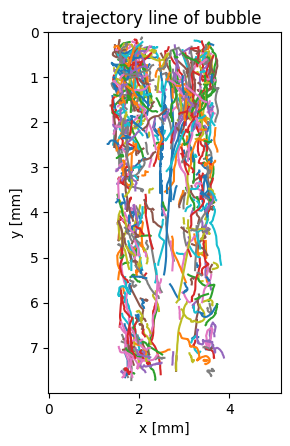

In [302]:
range_frame=[1300,2000]
groups_range_frame = df_filtered_vec.groupby('New_Identity').filter(lambda x: (x['frame'] >= range_frame[0]).any() and (x['frame'] <= range_frame[1]).any())

ratio = 3/656
# プロットの作成
plt.figure(figsize=(656*ratio, 1024*ratio))
for identity, group in groups_range_frame.groupby('New_Identity'):
    # if identity !=136:continue
    # print(group.shape)
    plt.plot(group['center_X']*scale_mm_px, group['center_Y']*scale_mm_px,  linestyle='-', label=f'Identity {identity}')

plt.xlabel('x [mm]')
plt.ylabel('y [mm]')
plt.title('trajectory line of bubble ')

plt.axis('equal')
# plt.grid()

plt.ylim(0, 1024*scale_mm_px)
plt.xlim(0,656*scale_mm_px)
# plt.legend()
plt.gca().invert_yaxis()  # y軸を上下反転する
plt.legend

<function matplotlib.pyplot.legend(*args, **kwargs) -> 'Legend'>

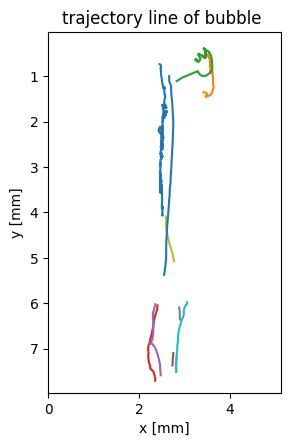

In [303]:
range_frame=[1300,1430]
groups_range_frame = df_filtered_vec.groupby('New_Identity').filter(lambda x: (x['frame'] >= range_frame[0]).any() and (x['frame'] <= range_frame[1]).any())
ratio = 3/656
# プロットの作成
plt.figure(figsize=(656*ratio, 1024*ratio))
for identity, group in groups_range_frame.groupby('New_Identity'):
    # if identity !=136:continue
    # print(group.shape)
    plt.plot(group['center_X']*scale_mm_px, group['center_Y']*scale_mm_px,  linestyle='-', label=f'Identity {identity}')

plt.xlabel('x [mm]')
plt.ylabel('y [mm]')
plt.title('trajectory line of bubble ')

plt.axis('equal')
# plt.grid()

plt.ylim(0, 1024*scale_mm_px)
plt.xlim(0,656*scale_mm_px)
# plt.legend()
plt.gca().invert_yaxis()  # y軸を上下反転する
plt.legend

<function matplotlib.pyplot.legend(*args, **kwargs) -> 'Legend'>

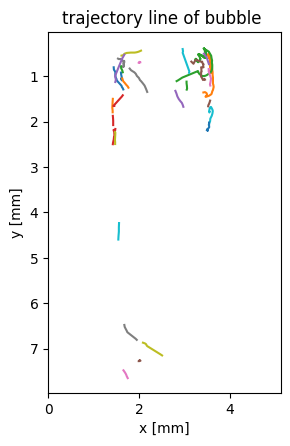

In [304]:
range_frame=[1460,1550]

groups_range_frame = df_filtered_vec.groupby('New_Identity').filter(lambda x: (x['frame'] >= range_frame[0]).any() and (x['frame'] <= range_frame[1]).any())

ratio = 3/656
# プロットの作成
plt.figure(figsize=(656*ratio, 1024*ratio))
for identity, group in groups_range_frame.groupby('New_Identity'):
    # if identity !=136:continue
    # print(group.shape)
    plt.plot(group['center_X']*scale_mm_px, group['center_Y']*scale_mm_px,  linestyle='-', label=f'Identity {identity}')

plt.xlabel('x [mm]')
plt.ylabel('y [mm]')
plt.title('trajectory line of bubble ')

plt.axis('equal')
# plt.grid()

plt.ylim(0, 1024*scale_mm_px)
plt.xlim(0,656*scale_mm_px)
# plt.legend()
plt.gca().invert_yaxis()  # y軸を上下反転する
plt.legend

<function matplotlib.pyplot.legend(*args, **kwargs) -> 'Legend'>

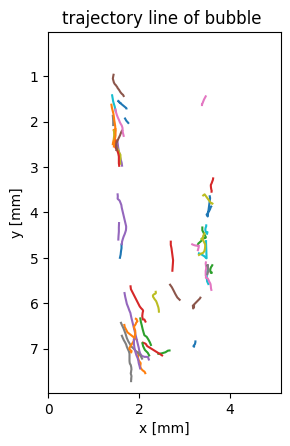

In [305]:
range_frame=[1551,1600]

groups_range_frame = df_filtered_vec.groupby('New_Identity').filter(lambda x: (x['frame'] >= range_frame[0]).any() and (x['frame'] <= range_frame[1]).any())


ratio = 3/656
# プロットの作成
plt.figure(figsize=(656*ratio, 1024*ratio))
for identity, group in groups_range_frame.groupby('New_Identity'):
    # if identity !=136:continue
    # print(group.shape)
    plt.plot(group['center_X']*scale_mm_px, group['center_Y']*scale_mm_px,  linestyle='-', label=f'Identity {identity}')

plt.xlabel('x [mm]')
plt.ylabel('y [mm]')
plt.title('trajectory line of bubble ')

plt.axis('equal')
# plt.grid()

plt.ylim(0, 1024*scale_mm_px)
plt.xlim(0,656*scale_mm_px)
# plt.legend()
plt.gca().invert_yaxis()  # y軸を上下反転する
plt.legend

<function matplotlib.pyplot.legend(*args, **kwargs) -> 'Legend'>

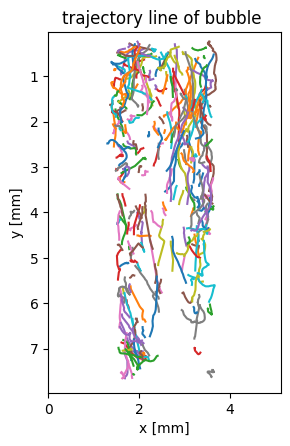

In [306]:
range_frame=[1600,1700]

groups_range_frame = df_filtered_vec.groupby('New_Identity').filter(lambda x: (x['frame'] >= range_frame[0]).any() and (x['frame'] <= range_frame[1]).any())


ratio = 3/656
# プロットの作成
plt.figure(figsize=(656*ratio, 1024*ratio))
for identity, group in groups_range_frame.groupby('New_Identity'):
    # if identity !=136:continue
    # print(group.shape)

    plt.plot(group['center_X']*scale_mm_px, group['center_Y']*scale_mm_px,  linestyle='-', label=f'Identity {identity}')

plt.xlabel('x [mm]')
plt.ylabel('y [mm]')
plt.title('trajectory line of bubble ')

plt.axis('equal')
# plt.grid()

plt.ylim(0, 1024*scale_mm_px)
plt.xlim(0,656*scale_mm_px)
# plt.legend()
plt.gca().invert_yaxis()  # y軸を上下反転する
plt.legend

<function matplotlib.pyplot.legend(*args, **kwargs) -> 'Legend'>

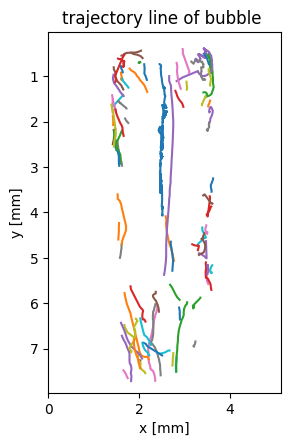

In [307]:
range_frame=[1300,1600]

groups_range_frame = df_filtered_vec.groupby('New_Identity').filter(lambda x: (x['frame'] >= range_frame[0]).any() and (x['frame'] <= range_frame[1]).any())


ratio = 3/656
# プロットの作成
plt.figure(figsize=(656*ratio, 1024*ratio))
for identity, group in groups_range_frame.groupby('New_Identity'):
    # if identity !=136:continue
    # print(group.shape)
    plt.plot(group['center_X']*scale_mm_px, group['center_Y']*scale_mm_px,  linestyle='-', label=f'Identity {identity}')

plt.xlabel('x [mm]')
plt.ylabel('y [mm]')
plt.title('trajectory line of bubble ')

plt.axis('equal')
# plt.grid()

plt.ylim(0, 1024*scale_mm_px)
plt.xlim(0,656*scale_mm_px)
# plt.legend()
plt.gca().invert_yaxis()  # y軸を上下反転する
plt.legend

<function matplotlib.pyplot.legend(*args, **kwargs) -> 'Legend'>

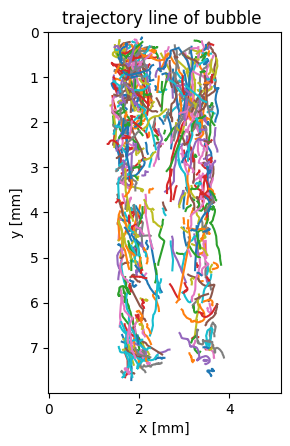

In [308]:
range_frame=[1550,2000]

groups_range_frame = df_filtered_vec.groupby('New_Identity').filter(lambda x: (x['frame'] >= range_frame[0]).any() and (x['frame'] <= range_frame[1]).any())


ratio = 3/656
# プロットの作成
plt.figure(figsize=(656*ratio, 1024*ratio))
for identity, group in groups_range_frame.groupby('New_Identity'):
    # if identity !=136:continue
    # print(group.shape)
    plt.plot(group['center_X']*scale_mm_px, group['center_Y']*scale_mm_px,  linestyle='-', label=f'Identity {identity}')

plt.xlabel('x [mm]')
plt.ylabel('y [mm]')
plt.title('trajectory line of bubble ')

plt.axis('equal')
# plt.grid()

plt.ylim(0, 1024*scale_mm_px)
plt.xlim(0,656*scale_mm_px)
# plt.legend()
plt.gca().invert_yaxis()  # y軸を上下反転する
plt.legend

# カラーマップ表示

(128, 4)


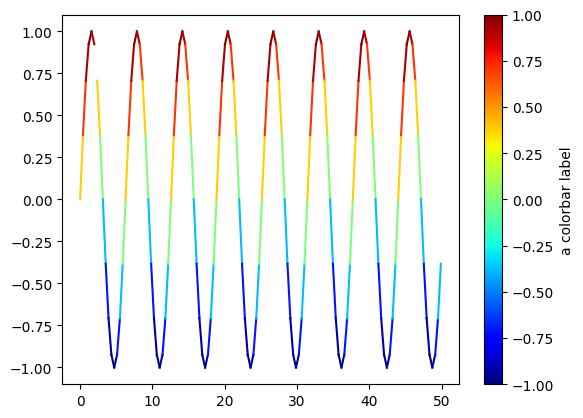

In [309]:
import matplotlib.pyplot as plt
import math
import matplotlib
import matplotlib as mpl

N=128
f = 8
omg = [i*f*2*math.pi/N for i in range(N)]
sig = [math.sin(i) for i in omg]

fig,(ax) = plt.subplots(1,1)
colormap = plt.get_cmap('jet')
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)

c = colormap(norm(sig))

print(c.shape)
for j in range(len(sig)-1):
    if j==5: continue
    im = ax.plot(omg[j:j+2], sig[j:j+2], color=c[j+1])

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='jet'),
             ax=ax, orientation='vertical', label='a colorbar label')
plt.show()

In [310]:
array_cos = df_filtered_vec.cos_from_flow.values
print(array_cos[~np.isnan(array_cos)].shape)

(28501,)


<function matplotlib.pyplot.legend(*args, **kwargs) -> 'Legend'>

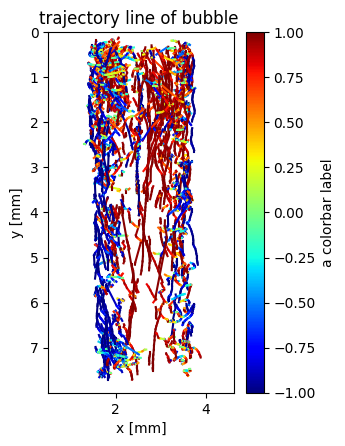

In [311]:
range_frame=[1300,2000]
groups_range_frame = df_filtered_vec.groupby('New_Identity').filter(lambda x: (x['frame'] >= range_frame[0]).any() and (x['frame'] <= range_frame[1]).any())

ratio = 3/656
# プロットの作成

fig,ax = plt.subplots(1,1, figsize=(656*ratio, 1024*ratio))
colormap = plt.get_cmap('jet')
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)

for identity, group in groups_range_frame.groupby('New_Identity'):
    # if identity !=136:continue
    # print(group.shape)


    array_cos = group.cos_from_flow.values
    norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
    c = colormap(norm(array_cos))
    for j in range(len(array_cos)-1):
        # plt.plot()
        # print(group['center_X'].values[j:j+2].shape,c[j+1].shape)
        ax.plot(group['center_X'].values[j:j+2]*scale_mm_px, group['center_Y'].values[j:j+2]*scale_mm_px,  linestyle='-', label=f'Identity {identity}', color=c[j+1])

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='jet'),
             ax=ax, orientation='vertical', label='a colorbar label')

plt.xlabel('x [mm]')
plt.ylabel('y [mm]')
plt.title('trajectory line of bubble ')

plt.axis('equal')
# plt.grid()

plt.ylim(0, 1024*scale_mm_px)
plt.xlim(0,656*scale_mm_px)
# plt.legend()
plt.gca().invert_yaxis()  # y軸を上下反転する
plt.legend

<function matplotlib.pyplot.legend(*args, **kwargs) -> 'Legend'>

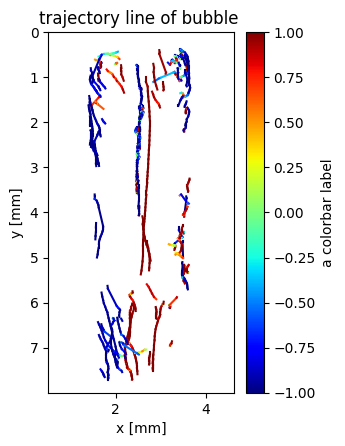

In [312]:
range_frame=[1300,1600]
groups_range_frame = df_filtered_vec.groupby('New_Identity').filter(lambda x: (x['frame'] >= range_frame[0]).any() and (x['frame'] <= range_frame[1]).any())

ratio = 3/656
# プロットの作成

fig,ax = plt.subplots(1,1, figsize=(656*ratio, 1024*ratio))
colormap = plt.get_cmap('jet')
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)

for identity, group in groups_range_frame.groupby('New_Identity'):
    # if identity !=136:continue
    # print(group.shape)


    array_cos = group.cos_from_flow.values
    norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
    c = colormap(norm(array_cos))
    for j in range(len(array_cos)-1):
        # plt.plot()
        # print(group['center_X'].values[j:j+2].shape,c[j+1].shape)
        ax.plot(group['center_X'].values[j:j+2]*scale_mm_px, group['center_Y'].values[j:j+2]*scale_mm_px,  linestyle='-', label=f'Identity {identity}', color=c[j+1])

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='jet'),
             ax=ax, orientation='vertical', label='a colorbar label')

plt.xlabel('x [mm]')
plt.ylabel('y [mm]')
plt.title('trajectory line of bubble ')

plt.axis('equal')
# plt.grid()

plt.ylim(0, 1024*scale_mm_px)
plt.xlim(0,656*scale_mm_px)
# plt.legend()
plt.gca().invert_yaxis()  # y軸を上下反転する
plt.legend

<function matplotlib.pyplot.legend(*args, **kwargs) -> 'Legend'>

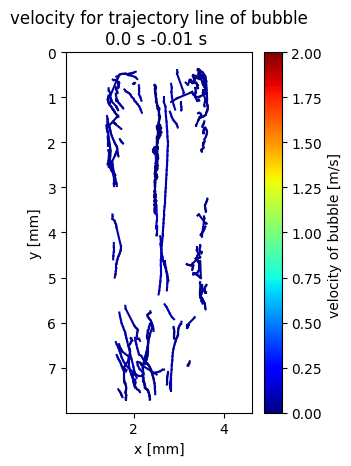

In [313]:
range_frame=np.array([1300,1600])
range_time=(range_frame-1300)/fps
groups_range_frame = df_filtered_vec.groupby('New_Identity').filter(lambda x: (x['frame'] >= range_frame[0]).any() and (x['frame'] <= range_frame[1]).any())

ratio = 3/656
# プロットの作成
scale_vec= scale_mm_px*frame/1000

fig,ax = plt.subplots(1,1, figsize=(656*ratio, 1024*ratio))
colormap = plt.get_cmap('jet')
array_range_norm=groups_range_frame.vec_val.values
array_range_norm=array_range_norm[~np.isnan(array_range_norm)]*scale_vec
norm = matplotlib.colors.Normalize(vmin=array_range_norm.min(), vmax=2)

for identity, group in groups_range_frame.groupby('New_Identity'):
    # if identity !=136:continue
    # print(group.shape)


    array_cos = group.vec_val.values*scale_vec

    c = colormap(norm(array_cos))
    for j in range(len(array_cos)-1):
        # plt.plot()
        ax.plot(group['center_X'].values[j:j+2]*scale_mm_px, group['center_Y'].values[j:j+2]*scale_mm_px,  linestyle='-', label=f'Identity {identity}', color=c[j+1])

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='jet'),
             ax=ax, orientation='vertical', label='velocity of bubble [m/s] ')

plt.xlabel('x [mm]')
plt.ylabel('y [mm]')
plt.title(f'velocity for trajectory line of bubble\n{range_time[0]} s -{range_time[1]} s ')

plt.axis('equal')
# plt.grid()

plt.ylim(0, 1024*scale_mm_px)
plt.xlim(0,656*scale_mm_px)
# plt.legend()
plt.gca().invert_yaxis()  # y軸を上下反転する
plt.legend

<function matplotlib.pyplot.legend(*args, **kwargs) -> 'Legend'>

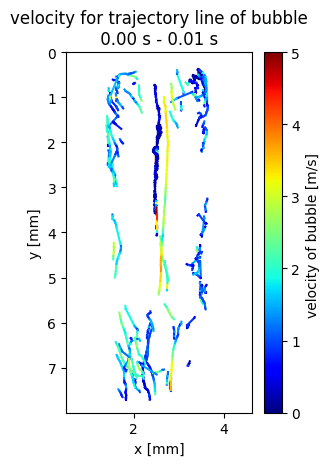

In [314]:
range_frame=np.array([1300,1600])
range_time=(range_frame-1300)/fps
groups_range_frame = df_filtered_vec.groupby('New_Identity').filter(lambda x: (x['frame'] >= range_frame[0]).any() and (x['frame'] <= range_frame[1]).any())

ratio = 3/656
# プロットの作成
scale_vec= scale_mm_px*fps/1000

fig,ax = plt.subplots(1,1, figsize=(656*ratio, 1024*ratio))
colormap = plt.get_cmap('jet')
array_range_norm=groups_range_frame.vec_val.values
array_range_norm=array_range_norm[~np.isnan(array_range_norm)]*scale_vec
norm = matplotlib.colors.Normalize(vmin=array_range_norm.min(), vmax=5)

for identity, group in groups_range_frame.groupby('New_Identity'):
    # if identity !=136:continue
    # print(group.shape)


    array_cos = group.vec_val.values*scale_vec

    c = colormap(norm(array_cos))
    for j in range(len(array_cos)-1):
        # plt.plot()
        ax.plot(group['center_X'].values[j:j+2]*scale_mm_px, group['center_Y'].values[j:j+2]*scale_mm_px,  linestyle='-', label=f'Identity {identity}', color=c[j+1])

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='jet'),
             ax=ax, orientation='vertical', label='velocity of bubble [m/s] ')

plt.xlabel('x [mm]')
plt.ylabel('y [mm]')
plt.title(f'velocity for trajectory line of bubble\n{range_time[0]: .2f} s -{range_time[1]: .2f} s ')

plt.axis('equal')
# plt.grid()

plt.ylim(0, 1024*scale_mm_px)
plt.xlim(0,656*scale_mm_px)
# plt.legend()
plt.gca().invert_yaxis()  # y軸を上下反転する
plt.legend

# 角度情報

<function matplotlib.pyplot.legend(*args, **kwargs) -> 'Legend'>

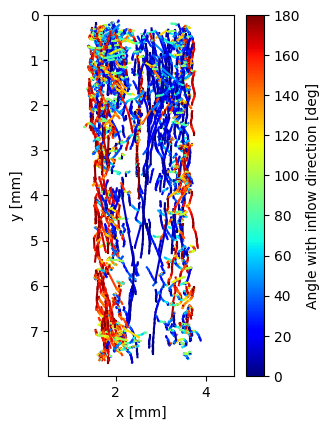

In [315]:
range_frame=[1300,2000]
groups_range_frame = df_filtered_vec.groupby('New_Identity').filter(lambda x: (x['frame'] >= range_frame[0]).any() and (x['frame'] <= range_frame[1]).any())

ratio = 3/656
# プロットの作成

fig,ax = plt.subplots(1,1, figsize=(656*ratio, 1024*ratio))
colormap = plt.get_cmap('jet')
norm = matplotlib.colors.Normalize(vmin=0, vmax=180)

for identity, group in groups_range_frame.groupby('New_Identity'):
    # if identity !=136:continue
    # print(group.shape)


    array_cos = np.degrees( np.arccos( group.cos_from_flow.values) )
    c = colormap(norm(array_cos))
    for j in range(len(array_cos)-1):
        # plt.plot()
        # print(group['center_X'].values[j:j+2].shape,c[j+1].shape)
        ax.plot(group['center_X'].values[j:j+2]*scale_mm_px, group['center_Y'].values[j:j+2]*scale_mm_px,  linestyle='-', label=f'Identity {identity}', color=c[j+1])

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='jet'),
             ax=ax, orientation='vertical', label='Angle with inflow direction [deg]')

plt.xlabel('x [mm]')
plt.ylabel('y [mm]')
# plt.title(' Angle of bubble direction \nwith inflow direction ')

plt.axis('equal')
# plt.grid()

plt.ylim(0, 1024*scale_mm_px)
plt.xlim(0,656*scale_mm_px)
# plt.legend()
plt.gca().invert_yaxis()  # y軸を上下反転する
plt.legend

# 流速

<function matplotlib.pyplot.legend(*args, **kwargs) -> 'Legend'>

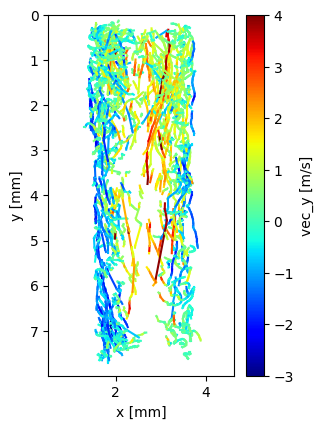

In [316]:
range_frame=[1550,2000]

groups_range_frame = df_filtered_vec.groupby('New_Identity').filter(lambda x: (x['frame'] >= range_frame[0]).any() and (x['frame'] <= range_frame[1]).any())

scale_vec= scale_mm_px*fps/1000
ratio = 3/656
# プロットの作成

fig,ax = plt.subplots(1,1, figsize=(656*ratio, 1024*ratio))
colormap = plt.get_cmap('jet')
norm = matplotlib.colors.Normalize(vmin=-3, vmax=4)

for identity, group in groups_range_frame.groupby('New_Identity'):
    # if identity !=136:continue
    # print(group.shape)


    array_vec_y =  -group.vec_Y.values*scale_vec
    c = colormap(norm(array_vec_y))
    for j in range(len(array_vec_y)-1):
        # plt.plot()
        # print(group['center_X'].values[j:j+2].shape,c[j+1].shape)
        ax.plot(group['center_X'].values[j:j+2]*scale_mm_px, group['center_Y'].values[j:j+2]*scale_mm_px,  linestyle='-', label=f'Identity {identity}', color=c[j+1])

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='jet'),
             ax=ax, orientation='vertical', label='vec_y [m/s]')

plt.xlabel('x [mm]')
plt.ylabel('y [mm]')
# plt.title(' Angle of bubble direction \nwith inflow direction ')

plt.axis('equal')
# plt.grid()

plt.ylim(0, 1024*scale_mm_px)
plt.xlim(0,656*scale_mm_px)
# plt.legend()
plt.gca().invert_yaxis()  # y軸を上下反転する
plt.legend

# 各追跡線の流速

405
244


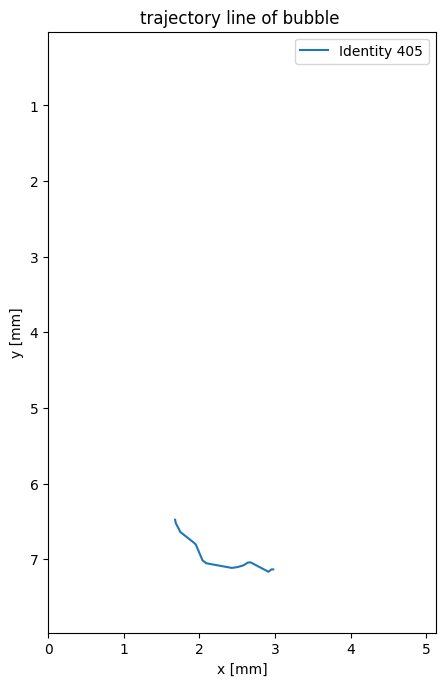

1216
339


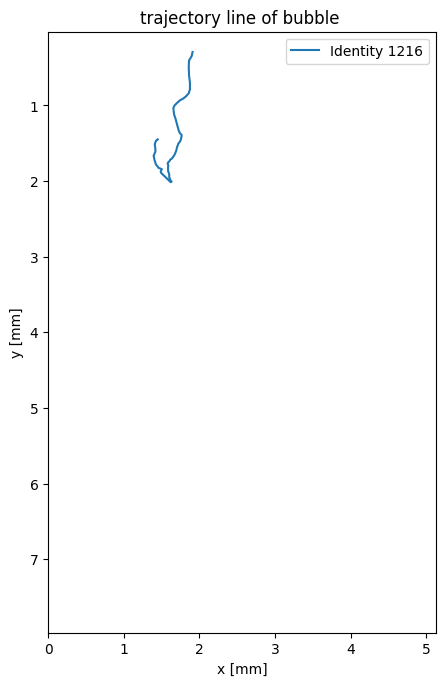

In [325]:
range_frame=[1550,2000]

groups_range_frame = df_filtered_vec.groupby('New_Identity').filter(lambda x: (x['frame'] >= range_frame[0]).any() and (x['frame'] <= range_frame[1]).any())


ratio = 5/656
# プロットの作成

for identity, group in groups_range_frame.groupby('New_Identity'):
    # if group.shape[0]<= 20: continue
    for p in [2707, 1216, 4040, 1582, 405]:
        if identity == p:

            plt.figure(figsize=(656*ratio, 1024*ratio))
            # if identity !=136:continue

            print(identity)
            print(group['frame'].min()-1300)
            plt.plot(group['center_X']*scale_mm_px, group['center_Y']*scale_mm_px,  linestyle='-', label=f'Identity {identity}')

            plt.xlabel('x [mm]')
            plt.ylabel('y [mm]')
            plt.title('trajectory line of bubble ')

            plt.axis('equal')
            # plt.grid()

            plt.ylim(0, 1024*scale_mm_px)
            plt.xlim(0,656*scale_mm_px)
            plt.legend()
            plt.gca().invert_yaxis()  # y軸を上下反転する
            plt.show()
            plt.close()

405
1544


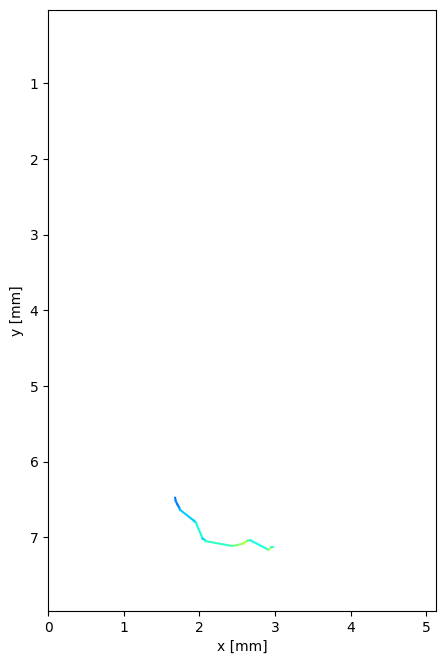

1216
1639


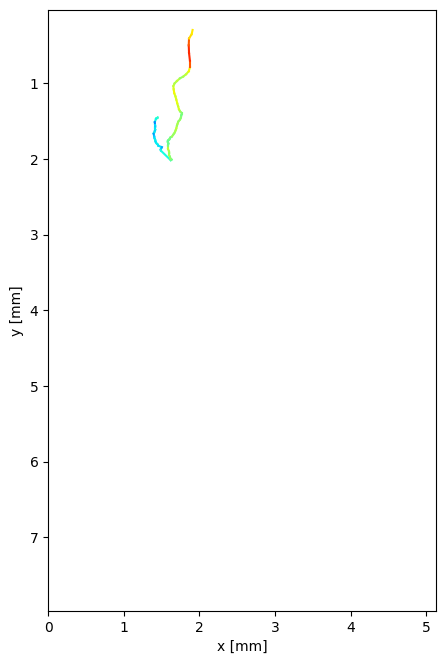

: 

In [326]:
range_frame=[1600,2000]
groups_range_frame = df_filtered_vec.groupby('New_Identity').filter(lambda x: (x['frame'] >= range_frame[0]).any() and (x['frame'] <= range_frame[1]).any())

scale_vec= scale_mm_px*fps/1000
ratio = 5/656
# プロットの作成



for identity, group in groups_range_frame.groupby('New_Identity'):
    for p in [2707, 1216, 4040, 1582, 405]:
        if identity == p:


            fig,ax = plt.subplots(1,1, figsize=(656*ratio, 1024*ratio))
            colormap = plt.get_cmap('jet')
            norm = matplotlib.colors.Normalize(vmin=-3, vmax=4)
            array_vec_y =  -group.vec_Y.values*scale_vec
            c = colormap(norm(array_vec_y))

            print(identity)
            print(group['frame'].min())

            for j in range(len(array_vec_y)-1):
                # plt.plot()
                # print(group['center_X'].values[j:j+2].shape,c[j+1].shape)
                ax.plot(group['center_X'].values[j:j+2]*scale_mm_px, group['center_Y'].values[j:j+2]*scale_mm_px,  linestyle='-', label=f'Identity {identity}', color=c[j+1])

            # fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='jet'),
            #             ax=ax, orientation='vertical', label='vec_y [m/s]')

            plt.xlabel('x [mm]')
            plt.ylabel('y [mm]')
            # plt.title(' Angle of bubble direction \nwith inflow direction ')

            plt.axis('equal')
            # plt.grid()

            plt.ylim(0, 1024*scale_mm_px)
            plt.xlim(0,656*scale_mm_px)
            # plt.legend()
            plt.gca().invert_yaxis()  # y軸を上下反転する
            plt.show()
            plt.close()



# せん断による気泡分裂
- Identity : 524
- frame : 1608-1644

939
1608


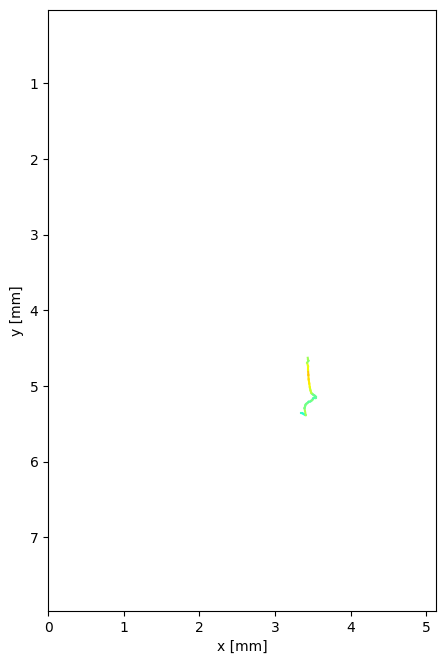

858

In [319]:
range_frame=[1600,2000]
groups_range_frame = df_filtered_vec.groupby('New_Identity').filter(lambda x: (x['frame'] >= range_frame[0]).any() and (x['frame'] <= range_frame[1]).any())

scale_vec= scale_mm_px*fps/1000
ratio = 5/656
# プロットの作成

fig,ax = plt.subplots(1,1, figsize=(656*ratio, 1024*ratio))
colormap = plt.get_cmap('jet')
norm = matplotlib.colors.Normalize(vmin=-3, vmax=4)


for identity, group in groups_range_frame.groupby('New_Identity'):
    for p in [939]:
        if identity == p:

            array_vec_y =  -group.vec_Y.values*scale_vec
            c = colormap(norm(array_vec_y))

            print(identity)
            print(group['frame'].min())

            for j in range(len(array_vec_y)-1):
                # plt.plot()
                # print(group['center_X'].values[j:j+2].shape,c[j+1].shape)
                ax.plot(group['center_X'].values[j:j+2]*scale_mm_px, group['center_Y'].values[j:j+2]*scale_mm_px,  linestyle='-', label=f'Identity {identity}', color=c[j+1])

            # fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='jet'),
            #             ax=ax, orientation='vertical', label='vec_y [m/s]')

plt.xlabel('x [mm]')
plt.ylabel('y [mm]')
# plt.title(' Angle of bubble direction \nwith inflow direction ')

plt.axis('equal')
# plt.grid()

plt.ylim(0, 1024*scale_mm_px)
plt.xlim(0,656*scale_mm_px)
# plt.legend()
plt.gca().invert_yaxis()  # y軸を上下反転する
plt.show()
plt.close()
858